### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [19]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dynamic Time Warping

In [20]:
def dynamic_time_warping(a, b):
    n = len(a)
    m = len(b)

    distances_row_1 = np.zeros(m)
    distances_row_2 = np.zeros(m)

    distances_row_1[:] = np.cumsum((a[0] - b[:]) ** 2)

    for i in range(1, n):
        distances_row_2[0] = (a[i] - b[0]) ** 2 + distances_row_1[0]
        for j in range(1, m):
            distances_row_2[j] = (a[i] - b[j]) ** 2 + min(distances_row_2[j - 1], min(distances_row_1[j - 1], distances_row_1[j]))
        distances_row_1[:] = distances_row_2

    return np.sqrt(distances_row_1[m - 1])

## Principal Component Analysis

In [21]:
def principal_component_analysis(df, k):
    # zero-mean the data
    df = df - df.mean()
    
    # compute eigenvalues from the covariance matrix C = 1/N * X^T * X
    covariance_matrix = 1/ df.shape[0] * df.T @ df
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # sort the eigenvalues and corresponding eigenvectors
    sorted_indices = np.flip(np.argsort(eigenvalues))
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvectors[:,:k]
    

def apply_principal_component_analysis(df, eigenvectors):
    # zero-mean the data
    df = df - df.mean()

    # apply the eigenvectors
    projected_data = df @ eigenvectors

    return pd.DataFrame(projected_data)

## Familiarization

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [22]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [23]:
def visualize_sensor_data(df, window=None, sensors=None, normalized=False):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        sensor_data = df[sensor][start_index:end_index]
        if normalized:
            sensor_data = (sensor_data - sensor_data.mean()) / (sensor_data.std() + 1e-9)
        plt.plot(df['Timestamp'][start_index:end_index], sensor_data, label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

C:\Users\vladu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


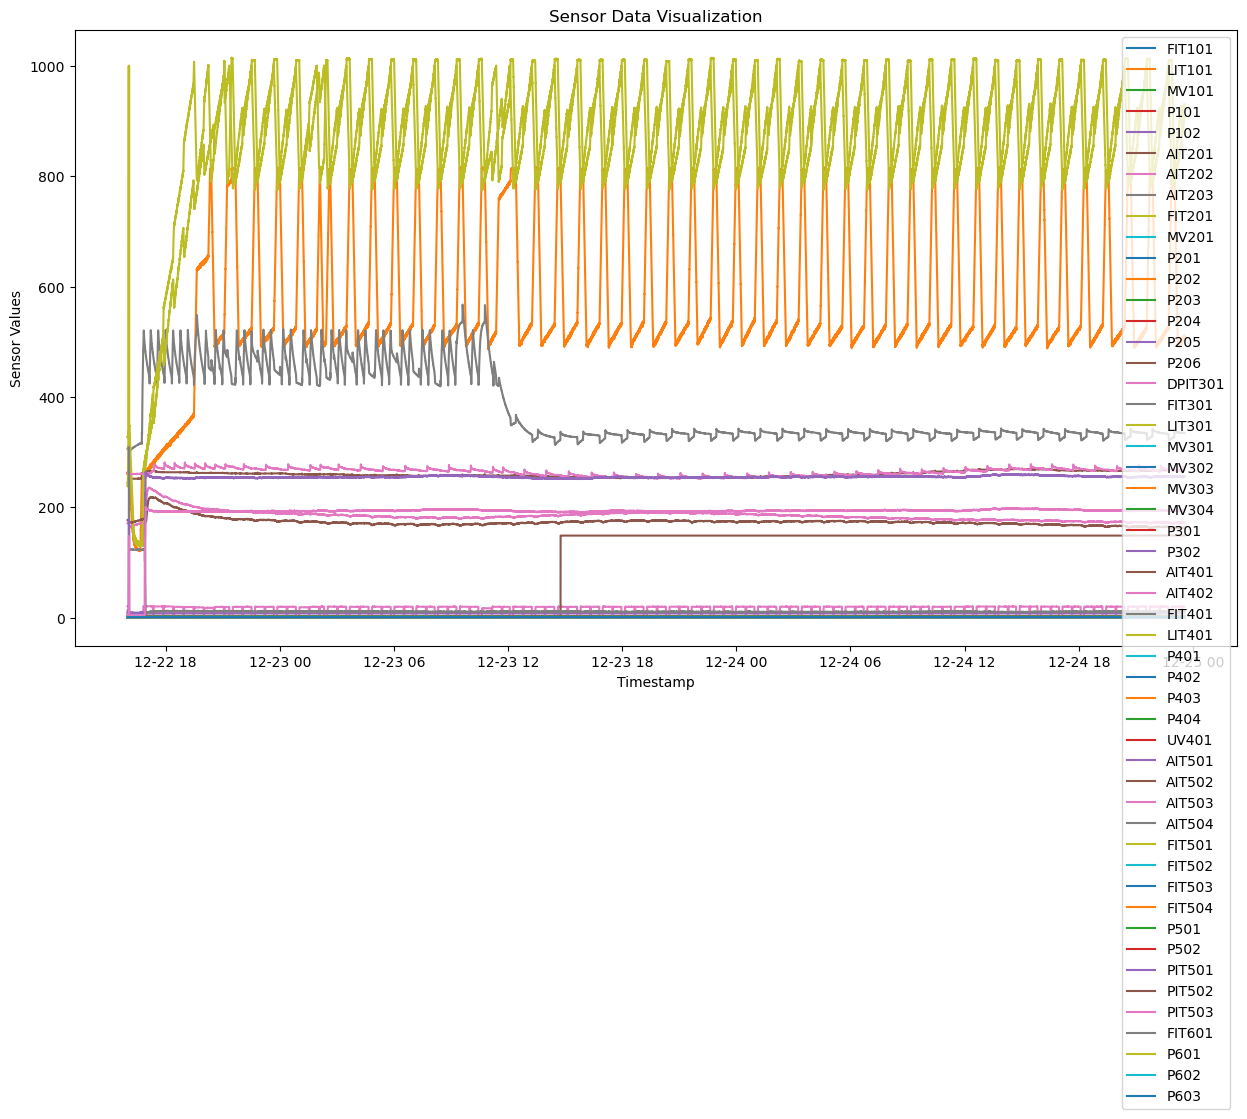

In [24]:
# Visualize first 200000 measurements from each sensor
visualize_sensor_data(train_data, window=(0, 200_000))

#### Types of signals
From the visualization, we can see there are 2 types of signals based on their values: continuously-valued and discretely-valued.
An example of a signal with continuous values can be seen in the following cell.

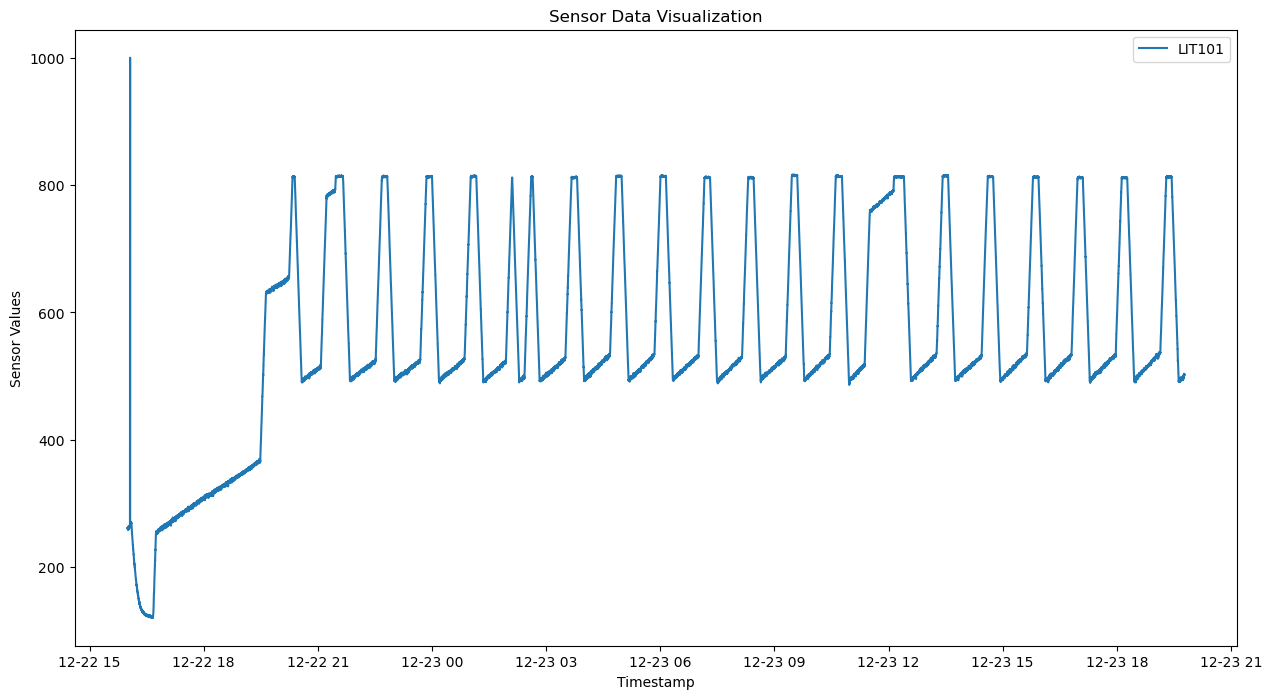

In [25]:
visualize_sensor_data(train_data, window=(0, 100_000), sensors=["LIT101"])

An example of a signal with discrete values can be seen in the following cell.

Measurements from MV101 take values from [0 1 2]


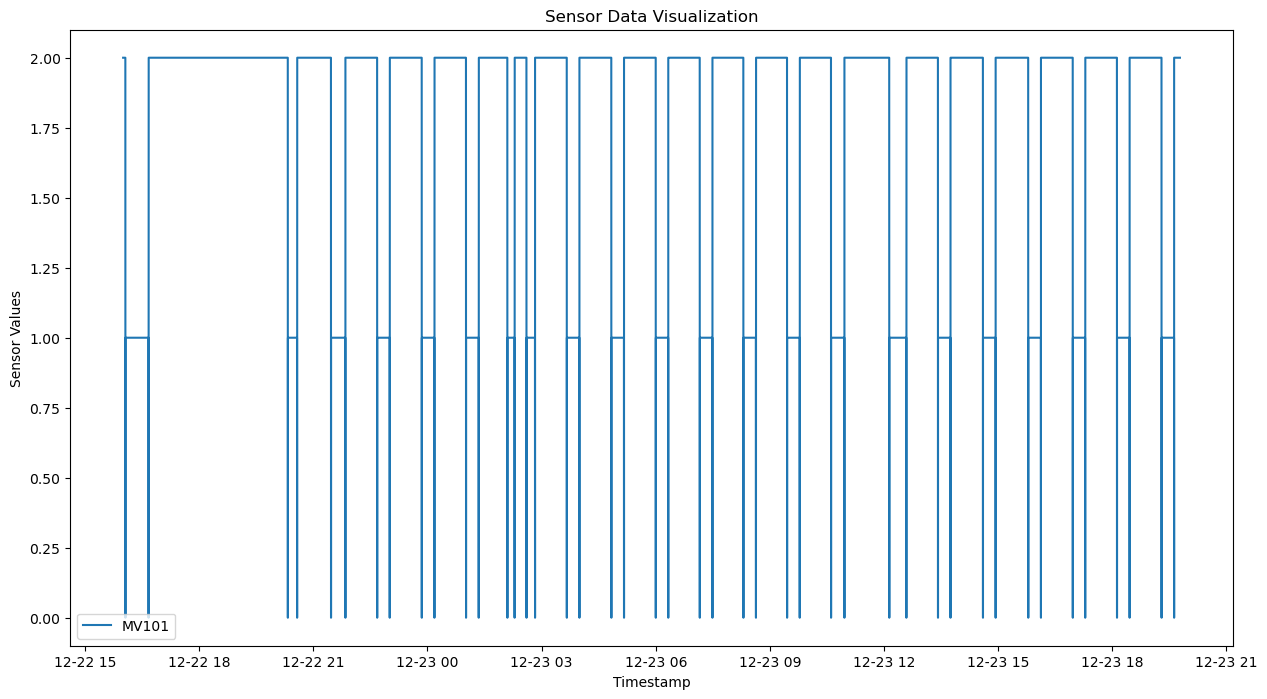

In [26]:
MV101_values = np.unique(train_data['MV101'])
print(f'Measurements from MV101 take values from {MV101_values}')
visualize_sensor_data(train_data, window=(0, 100_000), sensors=["MV101"])

#### Are the signals correlated? Do they show cyclic behavior?

Yes, we can see that some signals are correlated, following almost the same pattern. For example, let's take a look at signals LIT301 LIT401, plotted below. We can see that they follow a similar pattern (overlapping in some cases), with values ranging from 750-1000.
The behavior shown by most continuous sensor values can be described as cyclic, with repeating values over time. For example, referring back to LIT301, we can see that every (approximately) hour and 15 minutes, the signal reads the same value.

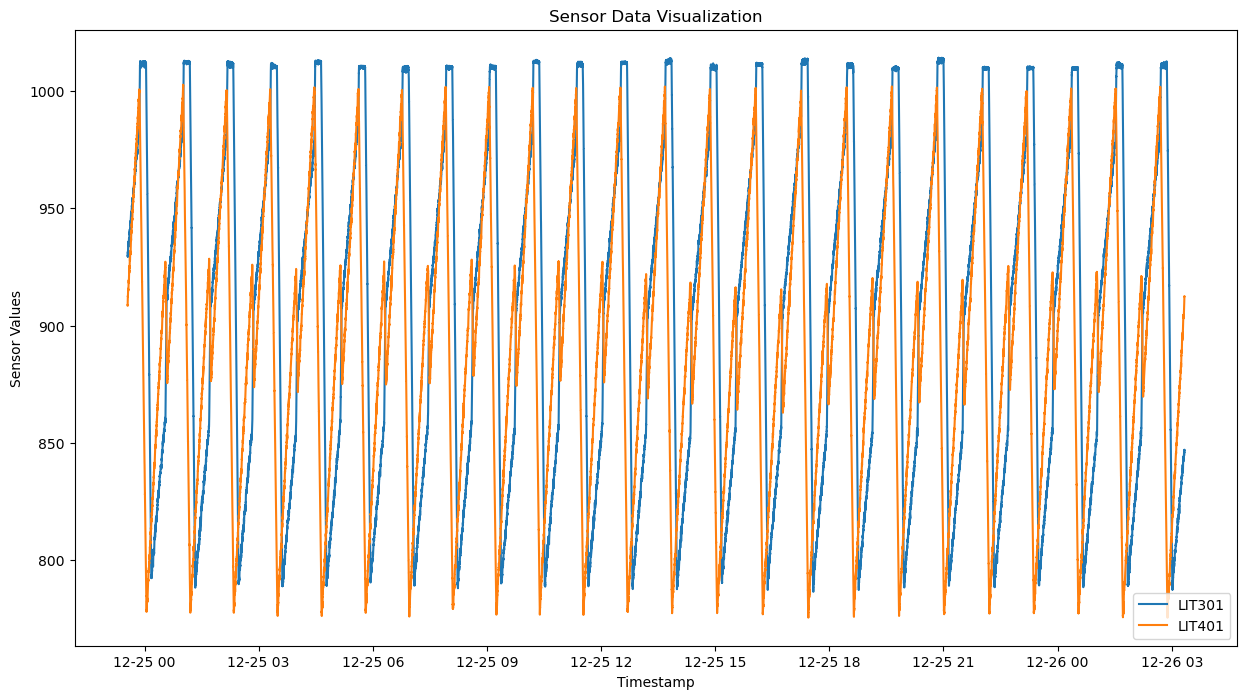

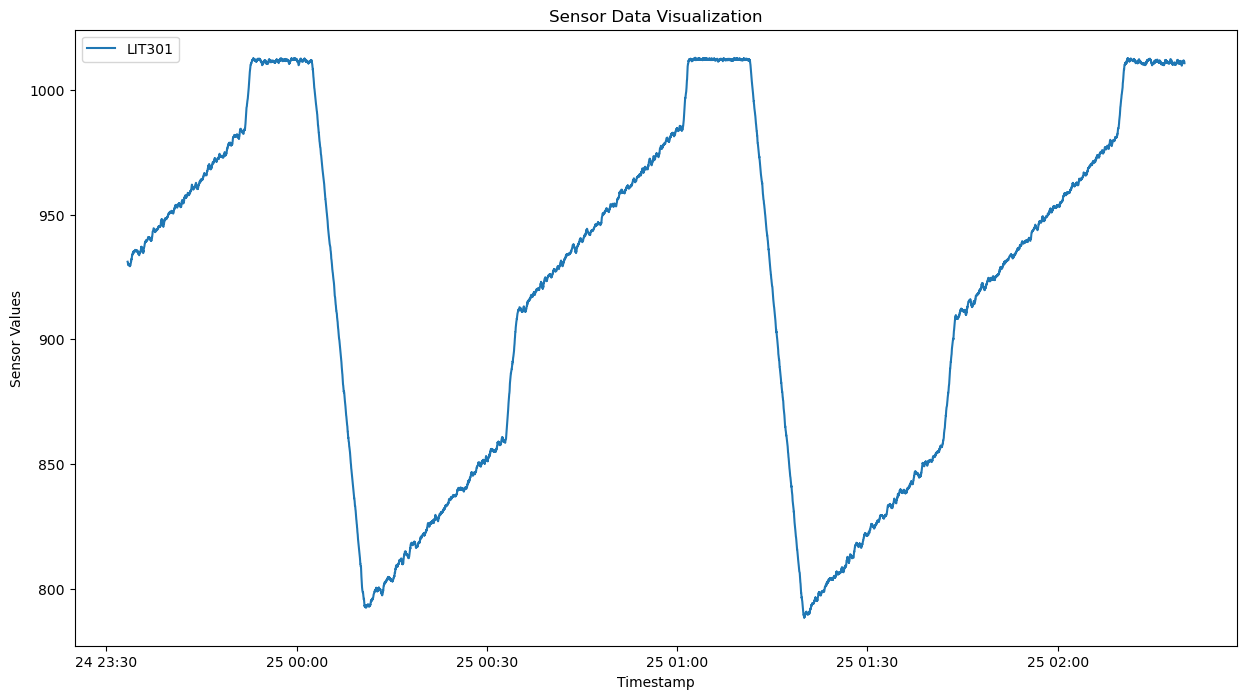

In [27]:
visualize_sensor_data(train_data, window=(200_000,300_000), sensors=["LIT301","LIT401"])
visualize_sensor_data(train_data, window=(200_000,210_000), sensors=["LIT301"])

## DTW-based anomaly detection
Below we are running an experiment on a single sensor, AIT504. First, we are visualizing some normal behaviour of the signal (we are ignoring the beginning of the series which shows some anomalous behaviour due to the start of the sensor device). 

Then, we are taking 4 windows representative of this pattern of size 500 each. We chose these windows, because their means are somewhat different (11, 10.5, 12, 13.5).

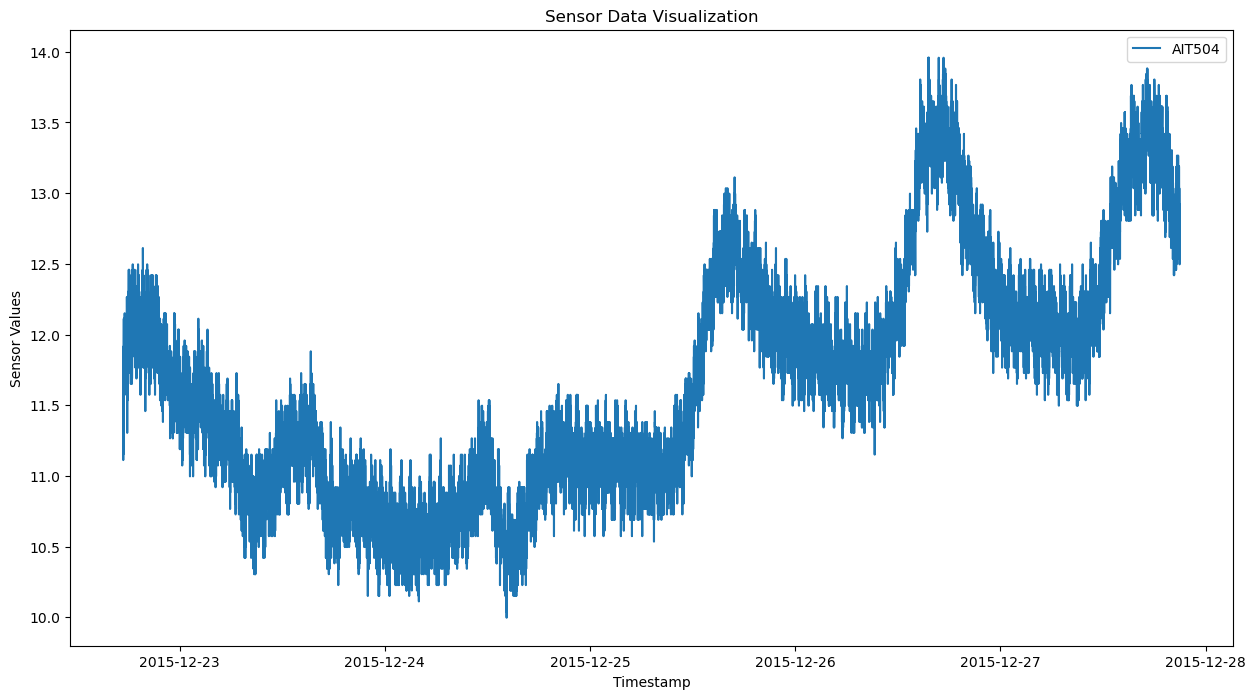

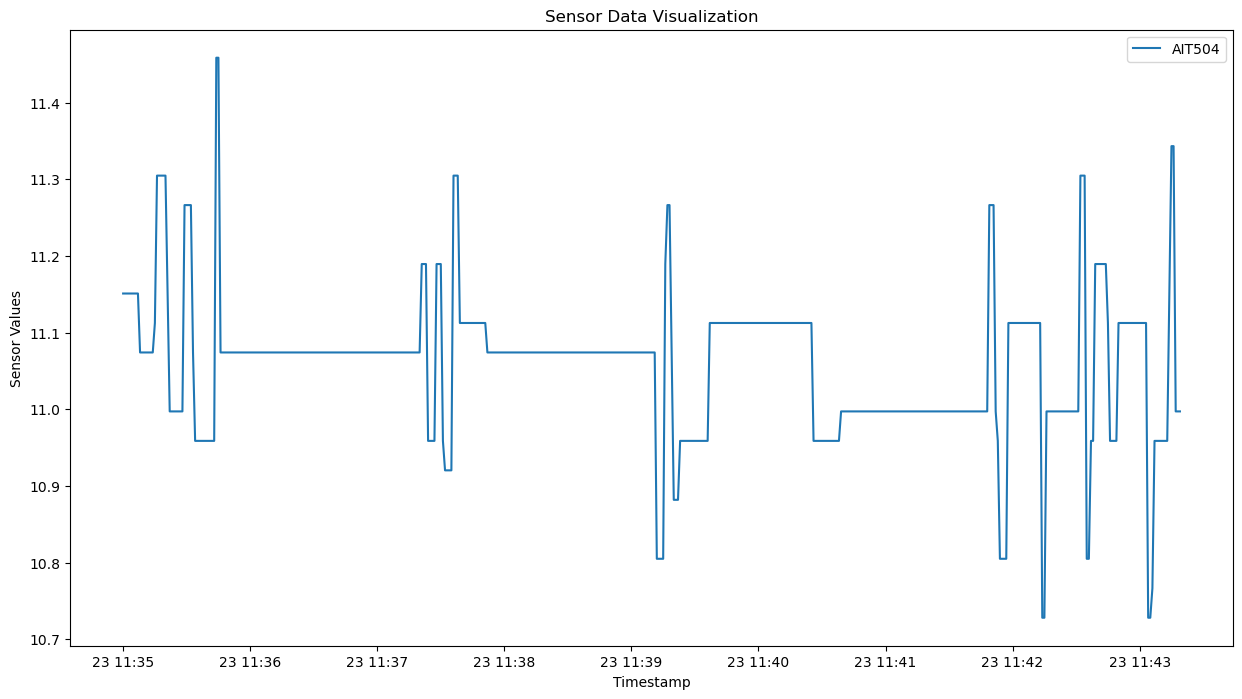

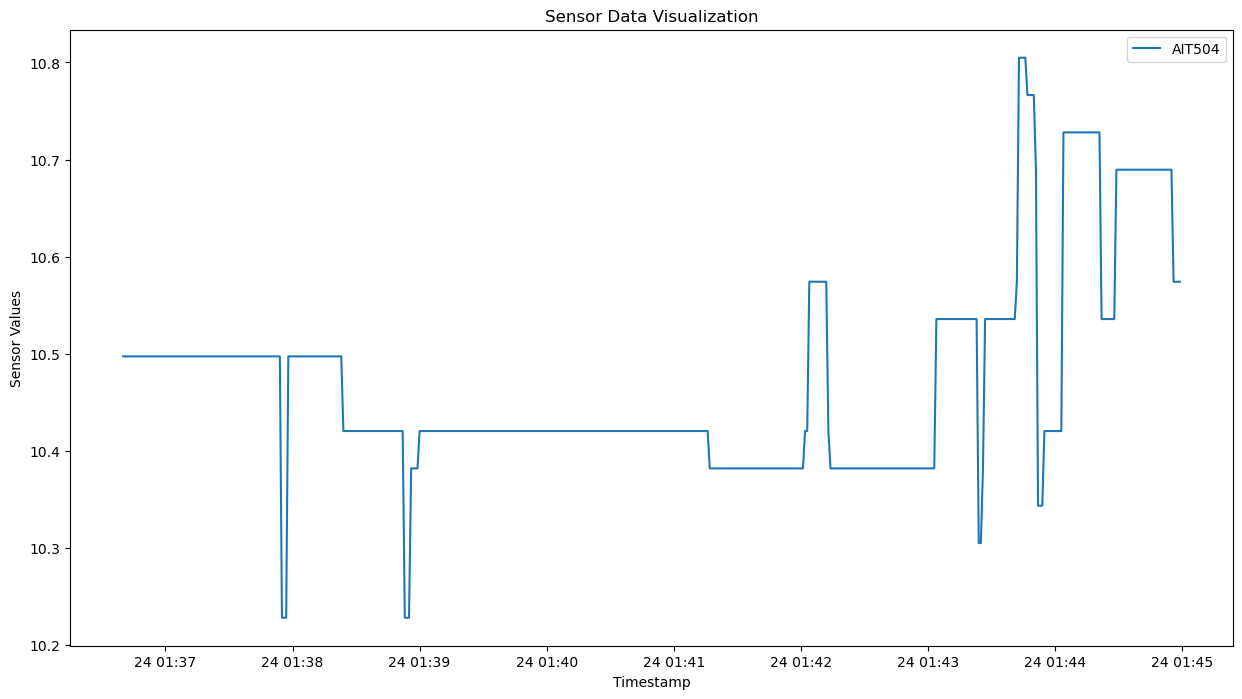

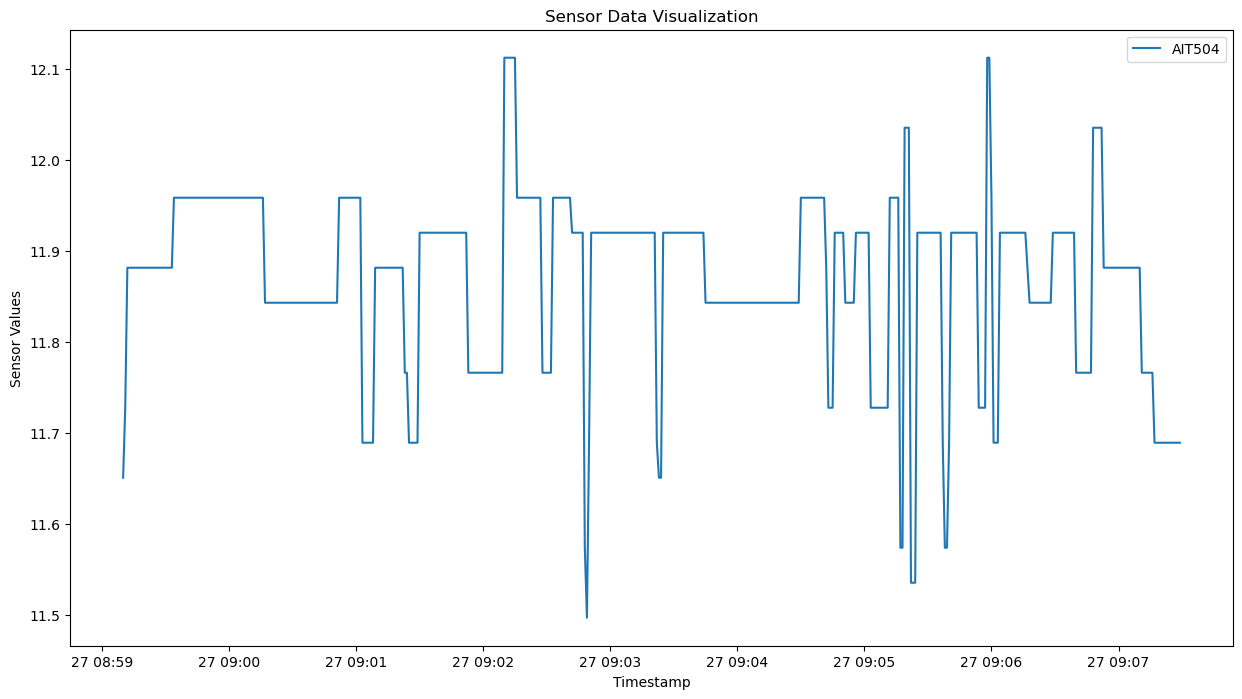

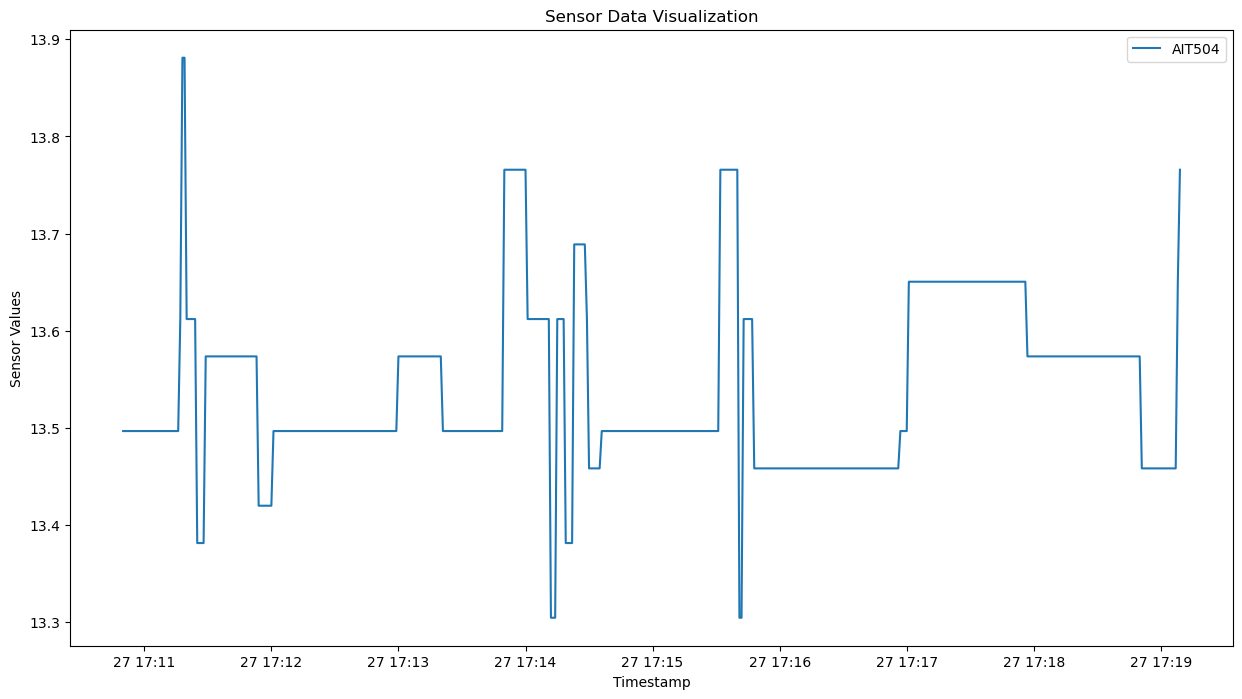

In [28]:
# visualize sensor data
visualize_sensor_data(train_data, window=(5000,450_000),sensors=['AIT504'])

aitTraining = train_data["AIT504"].values
aitTest = test_data['AIT504'].values

# data normalization
aitTraining = (aitTraining - np.mean(aitTraining)) / np.std(aitTraining)
aitTest = (aitTest - np.mean(aitTest)) / np.std(aitTest)

# define the representative windows
representative_windows = np.array([
        aitTraining[70_500:71_000],
        aitTraining[121_000:121_500],           
        aitTraining[406_750:407_250],
        aitTraining[436_250:436_750]
])

# visualize the representative windows
visualize_sensor_data(train_data, window=(70_500,71_000), sensors=['AIT504']) # window 1
visualize_sensor_data(train_data, window=(121_000,121_500), sensors=['AIT504']) #window 2
visualize_sensor_data(train_data, window=(406_750,407_250), sensors=['AIT504']) # window 3
visualize_sensor_data(train_data, window=(436_250,436_750), sensors=['AIT504']) # window 4

To identify anomalies in the test data, we are first setting a threshold on the residual. By setting the threshold as residual mean + 3 * standard deviation, we assume that 99.7% of the train data is normal.

In [38]:
# This code cell below should run in ~1 min

# TODO REMOVE
from tqdm import tqdm

# randomly sample 100 sliding windows from the train data (stride is 250)
residuals = []
train_windows = np.lib.stride_tricks.sliding_window_view(aitTraining[5000 : 450_000], window_shape=500)[::250]
random_windows = train_windows[np.random.choice(train_windows.shape[0], size=100, replace=False)]

for train_window in tqdm(random_windows):
    # find the closest representative window
    temp = np.zeros(representative_windows.shape[0])
    for k, representative_window in enumerate(representative_windows):
        temp[k] = dynamic_time_warping(representative_window, train_window)     
    residuals.append(np.amin(temp))
residuals = np.array(residuals)

# set the threshold
threshold = np.mean(residuals) + 3 * np.std(residuals)
print(f'Threshold is {threshold}')

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

Threshold is 16.2580327083055


Now, let's have a look at the test data. As we can see in the plot below, there are 2 major peaks that we wish to identify as anomalies.

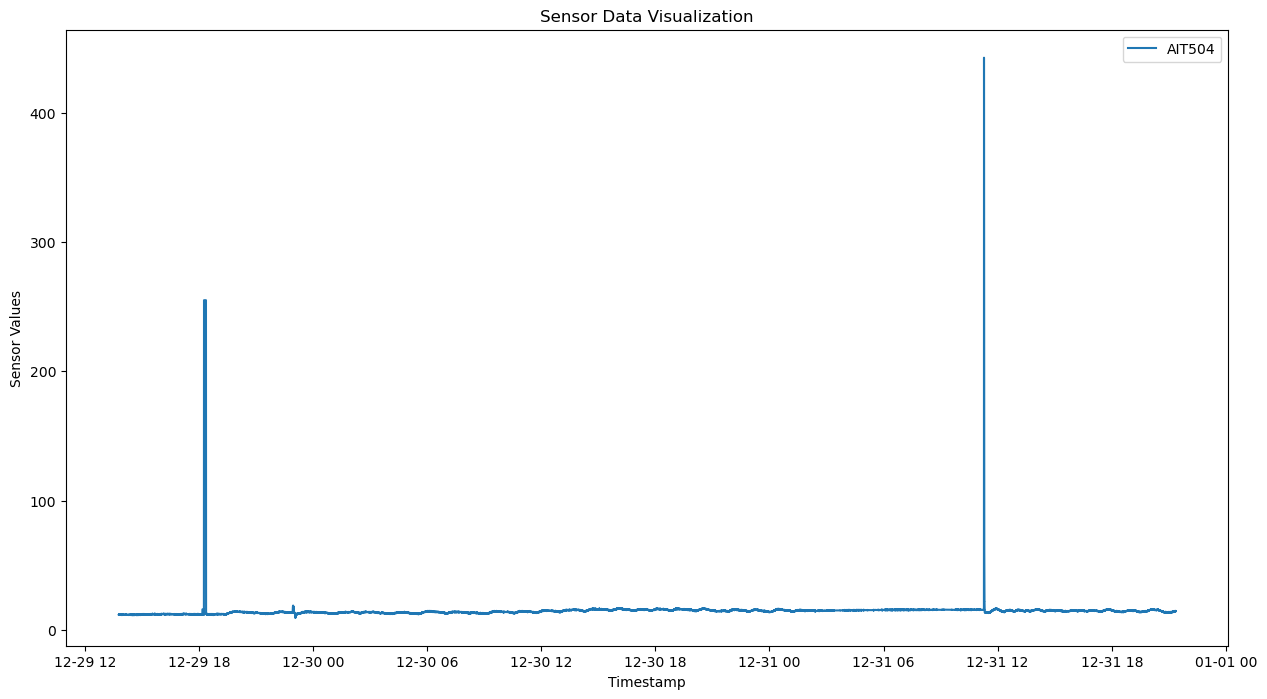

In [30]:
visualize_sensor_data(test_data, window=(100_000, 300_000), sensors=['AIT504'])

We have 400 tumbling test windows.


100%|██████████| 400/400 [04:16<00:00,  1.56it/s]


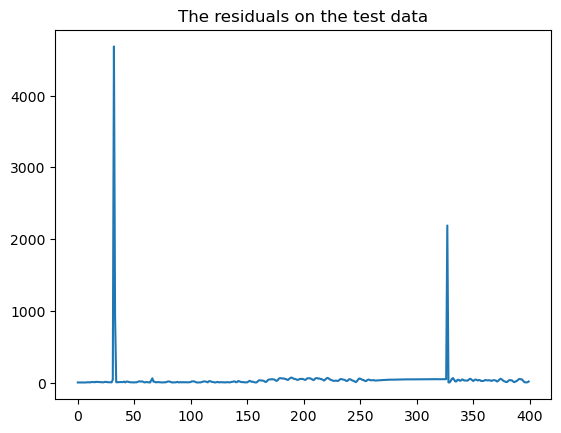

We found 240 anomalies.


In [41]:
# This code cell below should run in ~5 min

# use tumbling windows on test data for anomaly detection (stride is 500)
test_windows = np.lib.stride_tricks.sliding_window_view(aitTest[100_000 : 300_000], window_shape=500)[::500]
print(f'We have {test_windows.shape[0]} tumbling test windows.')

residuals = []
for test_window in tqdm(test_windows):
    # find the closest representative window
    temp = np.zeros(representative_windows.shape[0])
    for k, representative_window in enumerate(representative_windows):
        temp[k] = dynamic_time_warping(representative_window, test_window)
    residuals.append(np.amin(temp))
    
plt.plot(residuals)
plt.title('The residuals on the test data')
plt.show()

print(f'We found {np.count_nonzero(residuals > threshold)} anomalies.')

As we can see, the 2 peaks in the test data correspond to the 2 largest residuals in the plot above.

### What kind of anomalies do you expect to detect using DTW distances in this manner?

Using DTW distance, we should be able to detect contextual anomalies. When dealing with time series, we mark as anomalies groups of data points that deviate significantly from normal behaviour.

## PCA-based anomaly detection
